<div align="center" style="font-weight: bold; color:#fbb900">
    <div style="font-size: xx-large">Grado en Ingeniería Matemática e Inteligencia Artificial(iMAT)</div><br>
    <div style="font-size: x-large; color:gray">Tecnologia de Procesamiento de Big Data&ndash; SPARK</div><br>
    <div style="font-size: large; color:gray">Victoria García Martínez-Echevarría</div><br>
        <div style="font-size: large; color:gray">Escuela Técnica Superior de Ingeniería (ICAI)</div><br>
</div>

In [103]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import math
import pandas as pd
import subprocess
import plotly.express as px

from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (StringIndexer,
                                OneHotEncoder,
                                PCA,
                                PolynomialExpansion,
                                Tokenizer,
                                HashingTF,
                                VectorAssembler,
                                StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.pipeline import Pipeline


from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import PolynomialExpansion, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder

from pyspark.sql.functions import desc, row_number, dense_rank
from pyspark.sql.functions import lag, col

In [104]:
%%html
<style>
    .qst, .slides {background-color: #6fa2f2; padding:10px; border-radius: 5px; border: solid 2px #6fa2f2;}
    .qst:before, .slides:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color:  #6fa2f2;}
    .text_cell_render p, ul, ol {text-align: justify; text-justify: inter-word;}
    li {margin-bottom: 10px; margin-top: 10px;}
    div.output pre{border: 1px solid gray; border-radius: 1px; padding: 5px}
    td, th {font-size: 110%;}
</style>

In [105]:
user = 'abd08'
appName = user+'_cl1_<sparksql'
spark = SparkSession.builder.master("yarn") \
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [106]:
if not (("sc" in globals()) or ("sc" in locals())):
    sc = pyspark.SparkContext()

print(sc)

<SparkContext master=yarn appName=abd08_cl1_<sparksql>


In [107]:
sc

<SparkContext master=yarn appName=abd08_cl1_<sparksql>

In [109]:
# Procesado de los datos
spark.sql("USE real_estate")
df = spark.sql("SELECT * from data LIMIT 10")
df.show()

In [95]:
# LAG para predecir del día anterior
# Asumiendo que 'df' es un DataFrame de Spark que contiene los datos históricos
# Ordenamos los datos cronológicamente
windowSpec = Window.partitionBy("symbol").orderBy("date")

# Crear nuevas columnas para las características del día anterior
for feature in ["open", "close", "low", "volume", "high"]:
    data = data.withColumn(f"{feature}_prev_day", lag(df[feature]).over(windowSpec))

# Filtrar cualquier fila que tenga valores nulos resultantes de la función lag()
data = data.filter(col("open_prev_day").isNotNull())

# Seleccionamos la empresa WellTower
data = data.filter(F.col("symbol") == "WELL")
data.show(10)

+----------+------------------+------------------+------------------+---------+------------------+------+------------------+------------------+------------------+---------------+------------------+
|      date|              open|               low|             close|   volume|              high|symbol|     open_prev_day|    close_prev_day|      low_prev_day|volume_prev_day|     high_prev_day|
+----------+------------------+------------------+------------------+---------+------------------+------+------------------+------------------+------------------+---------------+------------------+
|2018-01-05|49.080068300545264| 48.58801713285858|48.712982177734375|2003300.0| 49.18941234238637|  WELL| 50.07198114525735| 49.01758575439453|48.994155738842615|      1993500.0| 50.10322315226108|
|2018-01-08| 48.73640873185491| 48.68173671815883|48.884803771972656|1623200.0| 49.08006181500188|  WELL|49.080068300545264|48.712982177734375| 48.58801713285858|      2003300.0| 49.18941234238637|
|2018-01-0

In [49]:
# Dividimos en train y test

# Ventana particionada por el símbolo y ordenada por fecha
windowSpec = Window.partitionBy('symbol').orderBy(desc('date'))

# Rango denso a cada fila dentro de cada grupo de empresa
data_with_rank = data.withColumn('rank', dense_rank().over(windowSpec))

# Obtener el número total de filas por cada empresa
total_rows_by_symbol = data_with_rank.groupBy('symbol').count()

# Filtrar los datos de prueba para incluir los últimos 7 días de cada empresa
test_data = data_with_rank.join(total_rows_by_symbol, 'symbol').where('rank <= 7').drop('rank', 'count')
train_data = data_with_rank.join(total_rows_by_symbol, 'symbol').where('rank > 7').drop('rank', 'count')

In [53]:
# Elegimos las columnas necesarias para predecir
features = ['open', 'close', 'low', 'volume', 'high']
# Definimos el VectorAssembler para transformar las características
assembler = VectorAssembler(inputCols=[f'{feature}_prev_day' for feature in features], outputCol="features")

## Random Forest

### Definimos el modelo

In [81]:
# RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="high")

# Crear un pipeline que encapsule VectorAssembler y RandomForestRegressor
pipeline = Pipeline(stages=[assembler, rf])

# Parámetros que se probarán en la búsqueda de la cuadrícula
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 75]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Evaluador
evaluator = RegressionEvaluator(labelCol="high", predictionCol="prediction", metricName="rmse")

# CrossValidator con el pipeline, el evaluador y los parámetros de la cuadrícula
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

# Entrenar el modelo utilizando solo el conjunto de entrenamiento
rfModel = crossval.fit(train_data_rf)

# Evaluar el modelo en el conjunto de prueba
test_predictions_rf = rfModel.transform(test_data_rf)

24/04/25 18:37:00 ERROR MapOutputTrackerMaster: head of empty list8:(41 + 8) / 200]0]
java.util.NoSuchElementException: head of empty list
	at scala.collection.immutable.Nil$.head(List.scala:469)
	at scala.collection.immutable.Nil$.head(List.scala:466)
	at org.apache.spark.MapOutputTrackerMaster$MessageLoop.handleStatusMessage(MapOutputTracker.scala:737)
	at org.apache.spark.MapOutputTrackerMaster$MessageLoop.run(MapOutputTracker.scala:763)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


### Observamos los mejores parámetros

In [82]:
# Accede al mejor modelo después del ajuste
bestModel = rfModel.bestModel

# Dentro del mejor modelo, accede al RandomForestRegressor (paso 2 en el pipeline)
bestRFModel = bestModel.stages[1]

# Extrae e imprime los mejores parámetros
print("Mejores parámetros:")
print(f"Número de árboles: {bestRFModel.getNumTrees}")
print(f"Máxima longitud: {bestRFModel.getMaxDepth()}")

Mejores parámetros:
Número de árboles: 75
Máxima longitud: 5


### Métricas de error

In [83]:
rmse = evaluator.evaluate(test_predictions_rf)
print("RMSE: ", rmse)

r2 = evaluator.evaluate(test_predictions_rf, {evaluator.metricName: "r2"})
print("R2: ", r2)

mae = evaluator.evaluate(test_predictions_rf, {evaluator.metricName: "mae"})
print("MAE", mae)

# Guardar el mejor modelo
rfModel.bestModel.write().overwrite().save("./modelRF")

RMSE:  1.053097481917254
MAE 0.9955755940905655
R2:  0.46677121056710746


In [85]:
# Añadir las predicciones del modelo al DataFrame de prueba
train_pd_rf = train_data_rf.toPandas()
test_pd_rf = test_data_rf.toPandas()

test_pd_rf['predictions'] = test_predictions_rf.select("prediction").toPandas()

# Concatenar los DataFrames de entrenamiento y prueba
full_data_rf = pd.concat([train_pd_rf, test_pd_rf])

# Asegurarse de que la fecha está en formato datetime para ordenar
full_data_rf['date'] = pd.to_datetime(full_data_rf['date'])

# Ordenar por fecha
full_data_rf = full_data_rf.sort_values('date')

### Gráfica

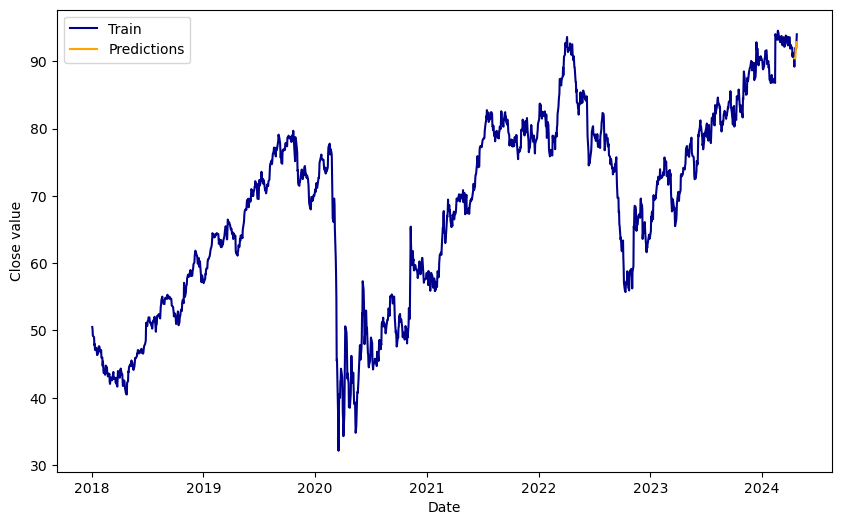

In [91]:
# Gráfica con los datos de entrenamiento para mostrar las predicciones 
# en el contexto de los datos de entrenamiento
plt.figure(figsize=(10, 6))

# Trama de los valores de entrenamiento
plt.plot(full_data_rf['date'], full_data_rf['high'], label='Train', color='darkblue')

# Trama de las predicciones del modelo en el conjunto de prueba
plt.plot(full_data_rf['date'], full_data_rf['predictions'], label='Predictions', color='orange')

plt.xlabel('Date')
plt.ylabel('Close value')
# plt.title('Plotted data')
plt.legend()

plt.show()

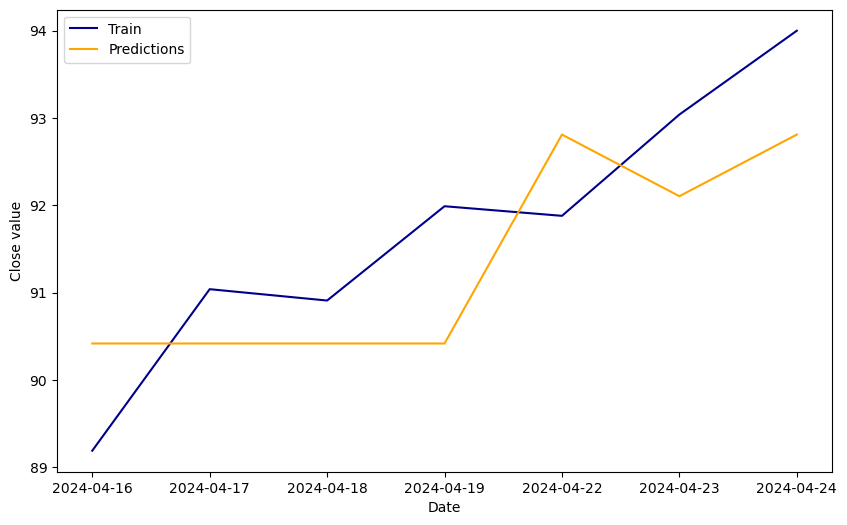

In [92]:
# Ordenamos los datos
test_pd_rf = test_pd_rf.sort_values('date')

# Definir el tamaño de la figura
plt.figure(figsize=(10, 6))

# Trama de los valores de entrenamiento
plt.plot(test_pd_rf['date'], test_pd_rf['high'], label='Train', color='darkblue')

# Trama de las predicciones del modelo en el conjunto de prueba
plt.plot(test_pd_rf['date'], test_pd_rf['predictions'], label='Predictions', color='orange')

# Etiquetas y leyenda
plt.xlabel('Date')
plt.ylabel('Close value')
# plt.title('Valores de entrenamiento, prueba y predicciones')
plt.legend()

# Mostrar la gráfica
plt.show()